In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
from sklearn.preprocessing import StandardScaler

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")



Using device: cpu


In [20]:
df = pd.read_csv('../data/raw/battery_failure_surfaces.csv')
df = df.drop(columns=['cumulative_high_temp_cycles'])
df['cell_id'] = (df.groupby('cell_chemistry')['cycle'].diff()<0).cumsum()

df = pd.get_dummies(df,columns=['cell_chemistry'],dtype=float)

In [21]:
df.head()

,cycle,charge_rate_C,discharge_rate_C,cell_temperature_C,internal_resistance_mOhm,capacity_retention_%,fast_charge_exposure_cycles,irreversible_damage_index,thermal_runaway_risk_score,cell_id,cell_chemistry_LFP,cell_chemistry_Li-ion NMC,cell_chemistry_Solid-State
0,0,1.311626,2.401429,33.544339,33.923862,99.972475,0,0.0,0.02,0,0.0,1.0,0.0
1,1,1.311626,2.401429,33.359694,33.947258,99.944950,0,0.0,0.02,0,0.0,1.0,0.0
2,2,1.311626,2.401429,33.787926,33.970654,99.917425,0,0.0,0.02,0,0.0,1.0,0.0
3,3,1.311626,2.401429,32.878808,33.994050,99.889901,0,0.0,0.02,0,0.0,1.0,0.0
4,4,1.311626,2.401429,32.150625,34.017447,99.862376,0,0.0,0.02,0,0.0,1.0,0.0


In [22]:
df.columns

Index(['cycle', 'charge_rate_C', 'discharge_rate_C', 'cell_temperature_C',
       'internal_resistance_mOhm', 'capacity_retention_%',
       'fast_charge_exposure_cycles', 'irreversible_damage_index',
       'thermal_runaway_risk_score', 'cell_id', 'cell_chemistry_LFP',
       'cell_chemistry_Li-ion NMC', 'cell_chemistry_Solid-State'],
      dtype='str')

In [23]:
FEATURE_COLS = [
    'charge_rate_C',
    'discharge_rate_C',
    'cell_temperature_C',
    'internal_resistance_mOhm', 
    'fast_charge_exposure_cycles', 
    'irreversible_damage_index',
    'capacity_retention_%',
    'thermal_runaway_risk_score', 
    'cell_chemistry_LFP',
    'cell_chemistry_Li-ion NMC', 
    'cell_chemistry_Solid-State'
]

# Columns to scale (exclude one-hot)
SCALE_COLS = [
    'charge_rate_C',
    'discharge_rate_C',
    'cell_temperature_C',
    'internal_resistance_mOhm',
    'capacity_retention_%',
    'fast_charge_exposure_cycles',
    'irreversible_damage_index',
    'thermal_runaway_risk_score',
]

TARGET =  'capacity_retention_%'

WINDOW_SIZE = 30

In [24]:
# Temporal split by cell
cell_ids = df[['cell_id']].drop_duplicates().sort_values('cell_id')
cell_keys = cell_ids['cell_id'].to_list()

n = len(cell_keys)

train_keys = set(cell_keys[:int(n*0.7)])
val_keys = set(cell_keys[int(n*0.7):int(n*0.85)])
test_keys = set(cell_keys[int(n*0.85):])

print(f"Train: {len(train_keys)} cells")
print(f"Val: {len(val_keys)} cells")
print(f"Test: {len(test_keys)} cells")


Train: 838 cells
Val: 180 cells
Test: 180 cells


In [25]:
# Tagging the records
df['split'] = df['cell_id'].map(
    lambda cid: "train" if cid in train_keys
    else 'val' if cid in val_keys
    else 'test'
)

# Scale — fit on train only
scaler = StandardScaler()
scaler.fit(df.loc[df['split'] == 'train', SCALE_COLS])
df[SCALE_COLS] = scaler.transform(df[SCALE_COLS])

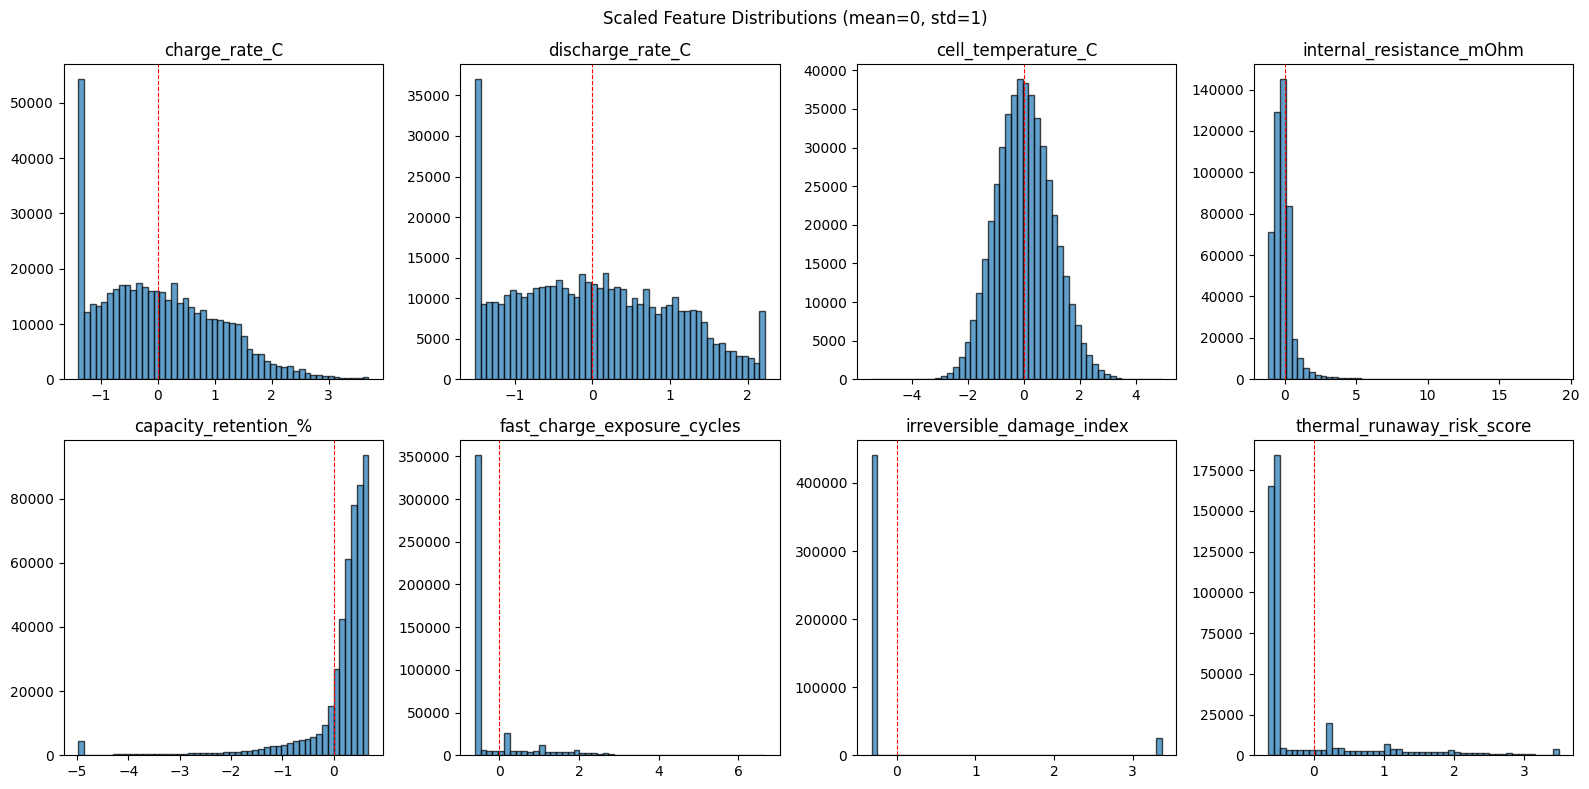

In [26]:
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i, col in enumerate(SCALE_COLS):
    axes[i].hist(df[col], bins=50, alpha=0.7, edgecolor='black')
    axes[i].set_title(col)
    axes[i].axvline(0, color='red', linestyle='--', linewidth=0.8)

plt.suptitle('Scaled Feature Distributions (mean=0, std=1)')
plt.tight_layout()
plt.show()

In [27]:
class BatteryWindowDataset(Dataset):

    def __init__(self,dataframe,feature_cols,target_col,window_size=30):
        self.samples = []

        for cell_id,group in dataframe.groupby('cell_id'):
            group = group.sort_values('cycle')
            features = group[feature_cols].values.astype(np.float32)
            target = group[target_col].values.astype(np.float32)

            for i in range(len(features) - window_size):
                x = features[i:i+window_size]
                y = target[i+window_size]
                self.samples.append((x,y))

    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self,idx):
        x,y = self.samples[idx]
        return torch.tensor(x), torch.tensor(y)
    
train_ds = BatteryWindowDataset(df[df['split']=='train'],FEATURE_COLS,TARGET,WINDOW_SIZE)
test_ds = BatteryWindowDataset(df[df['split']=='test'],FEATURE_COLS,TARGET,WINDOW_SIZE)
val_ds = BatteryWindowDataset(df[df['split']=='val'],FEATURE_COLS,TARGET,WINDOW_SIZE)

print(f'Train: {len(train_ds)} windows')
print(f'Val: {len(val_ds)} windows')
print(f'Test: {len(test_ds)} windows')

Train: 281525 windows
Val: 81397 windows
Test: 78391 windows


In [28]:
train_loader = DataLoader(train_ds,batch_size=256,shuffle=True)
val_loader = DataLoader(val_ds,batch_size=256,shuffle=False)
test_loader = DataLoader(test_ds,batch_size=256,shuffle=False)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Train batches: 1100
Val batches: 318
Test batches: 307


In [29]:
# Model Definition
class BatteryLSTM(nn.Module):
    def __init__(self,input_size,hidden_state=64,num_layers=2,dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_state,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout,
        )
        self.fc = nn.Linear(hidden_state,1)

    def forward(self,x):
        lstm_out, (h_n,c_n) = self.lstm(x)
        last_hidden = h_n[-1]
        out = self.fc(last_hidden)
        return out.squeeze(-1)


model = BatteryLSTM(input_size=len(FEATURE_COLS)).to(DEVICE)
print(f"Parameters: {sum(p.numel() for p in model.parameters()):}")
print(model)

Parameters: 53057
BatteryLSTM(
  (lstm): LSTM(11, 64, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


In [30]:
# Training Loop
def train_one_epoch(model,dataloader,optimizer,critirion):
    model.train()
    total_loss = 0
    n_batches = 0

    for X_batch,y_batch in dataloader:
        X_batch = X_batch.to(DEVICE)
        y_batch = y_batch.to(DEVICE)

        predictions = model(X_batch)
        loss = critirion(predictions,y_batch)
         
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        n_batches += 1

    return total_loss/n_batches

def evaluate(model,dataloader,critirion):
    model.eval()
    total_loss = 0
    n_batches = 0

    with torch.no_grad():
        for X_batch,y_batch in dataloader:
            X_batch = X_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE)

            predictions = model(X_batch)
            loss = critirion(predictions,y_batch)

            total_loss += loss.item()
            n_batches += 1

        return total_loss/n_batches



In [ ]:
def train_model(model,train_loader,val_loader,epochs=50,lr=0.003,patience=10):
    optimizer = torch.optim.Adam(model.parameters(),lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,mode='min',factor=0.5,patience=5
    )
    critirion = nn.MSELoss()

    best_val_loss = float('inf')
    patience_counter = 0
    history = {'train_loss': [], 'val_loss': []}

    for epoch in range(1,epochs+1):
        train_loss = train_one_epoch(model,train_loader,optimizer,critirion)
        val_loss = evaluate(model,val_loader,critirion)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(),'best_model.pt')
        else:
            patience_counter += 1 

       
            current_lr = optimizer.param_groups[0]['lr'] 
            print(f"Epoch {epoch:3d} | Train: {train_loss:.6f} | Val: {val_loss:.6f} | LR: {current_lr:.6f}")

        if patience < patience_counter:
            print(f'\nEarly Stopping at Epoch {epoch}')
            break
    
    model.load_state_dict(torch.load('best_model.pt'))
    return model,history

In [33]:
model, history = train_model(model, train_loader, val_loader)

KeyboardInterrupt: 